In [2]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.patches as patches
from scipy.interpolate import griddata

# Data adquisition and basic plotting

In [3]:
# data adquisition
_x2 = np.genfromtxt('./data/x2.csv', skip_header=1, delimiter=',')
_x3 = np.genfromtxt('./data/x3.csv', skip_header=1, delimiter=',')
_x  = np.genfromtxt('./data/x.csv', skip_header=1, delimiter=',')
_2x = np.genfromtxt('./data/2x.csv', skip_header=1, delimiter=',')
_3x = np.genfromtxt('./data/3x.csv', skip_header=1, delimiter=',')

# store the files inside lists
dataSets = [_x3, _x2, _x, _2x, _3x]
dataSetsString = ['x3', 'x2', 'x', '2x', '3x']

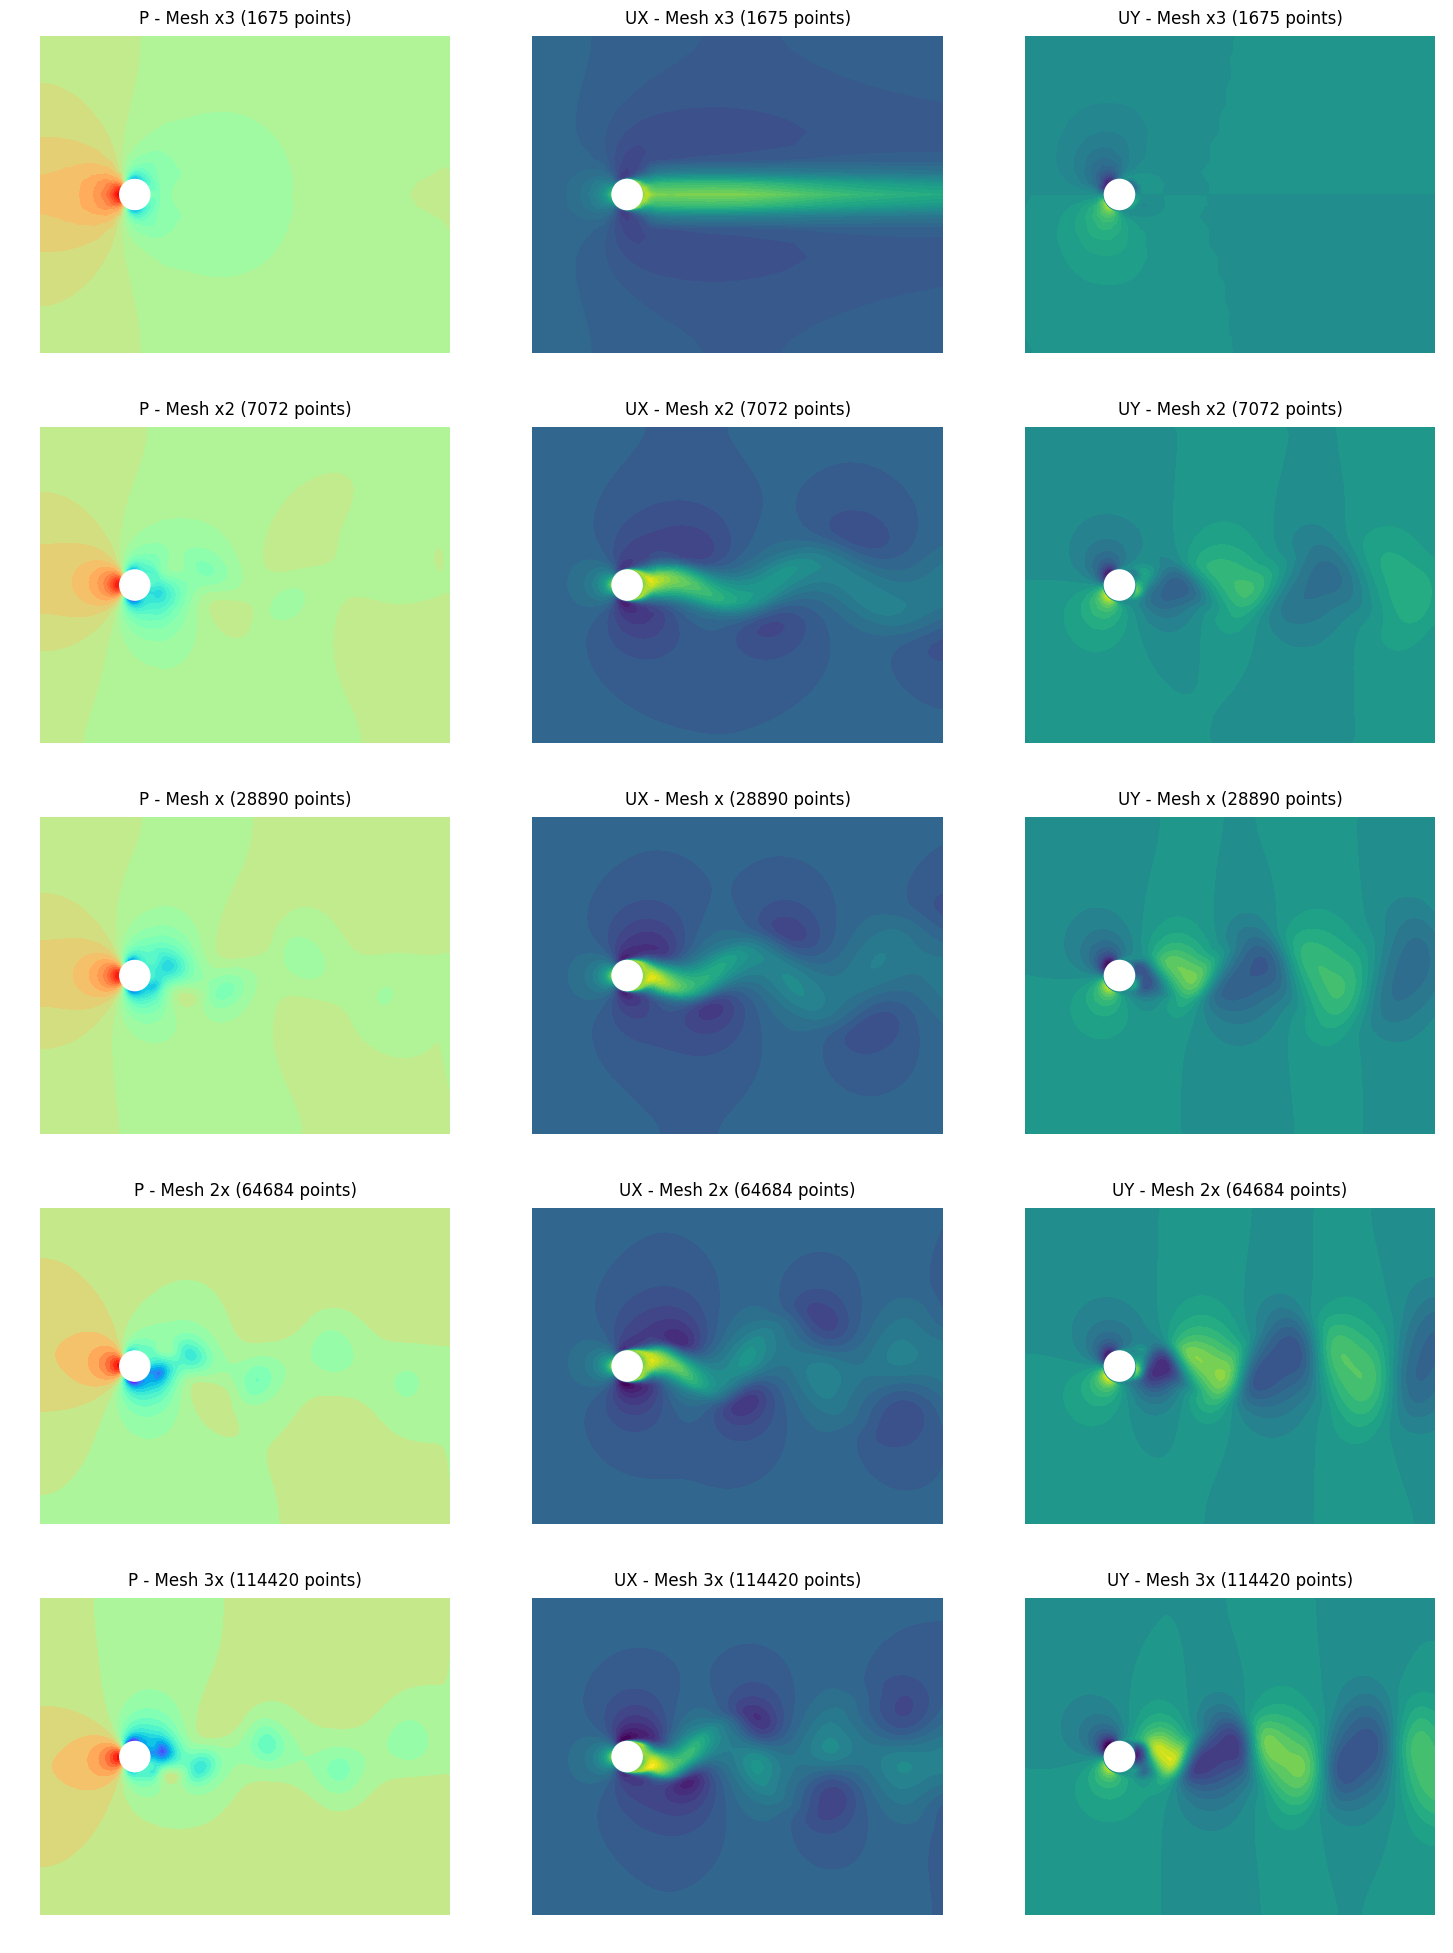

In [35]:
# basic potting
f, axes = plt.subplots(5, 3, sharex=True, figsize=(18,25), dpi=100)

# vertical levels for contours (more levels will take more time)
levels = 25

# minimum and maximum values for equal colorbars
# pressure plot
minVal0 = np.min([dataSets[i][:,0].min() for i in range(len(dataSets))])
maxVal0 = np.max([dataSets[i][:,0].min() for i in range(len(dataSets))])
# x-axis velocity
minVal1 = np.min([dataSets[i][:,0].min() for i in range(len(dataSets))])
maxVal1 = np.max([dataSets[i][:,0].min() for i in range(len(dataSets))])
# y-axis velocity
minVal2 = np.min([_x3[:,2].min(),_x2[:,2].min(),_x[:,2].min(),_2x[:,2].min(),_3x[:,2].min()])
maxVal2 = np.max([_x3[:,2].max(),_x2[:,2].max(),_x[:,2].max(),_2x[:,2].max(),_3x[:,2].max()])

# setting equal axis and then hiding the box
[axes[i][j].axis('equal') for j in range(3) for i in range(5)]
[axes[i][j].axis('off') for j in range(3) for i in range(5)]

# plot the same thing for all cases
for i in range(len(axes)):
    # pressure field
    axes[i][0].tricontourf(dataSets[i][:,4], dataSets[i][:,5], dataSets[i][:,0], levels, vmin = minVal0, vmax = maxVal0, cmap='rainbow')
    axes[i][0].add_patch(patches.Circle((0.0, 0.0), 0.5, facecolor="white"))
    axes[i][0].set_title('P - Mesh %s (%i points)' %(dataSetsString[i], len(dataSets[i][:,0])))
    # x-axis velocity field
    axes[i][1].tricontourf(dataSets[i][:,4], dataSets[i][:,5], dataSets[i][:,1], levels, vmin = minVal1, vmax = maxVal1, cmap='viridis_r')
    axes[i][1].add_patch(patches.Circle((0.0, 0.0), 0.5, facecolor="white"))
    axes[i][1].set_title('UX - Mesh %s (%i points)' %(dataSetsString[i], len(dataSets[i][:,1])))
    # y-axis velocity field    
    axes[i][2].tricontourf(dataSets[i][:,4], dataSets[i][:,5], dataSets[i][:,2], levels, vmin = minVal2, vmax = maxVal2, cmap='viridis_r')
    axes[i][2].add_patch(patches.Circle((0.0, 0.0), 0.5, facecolor="white"))
    axes[i][2].set_title('UY - Mesh %s (%i points)' %(dataSetsString[i], len(dataSets[i][:,2])))
    
plt.savefig('./cylinderMeshConv.png', bbox_inches='tight', dpi=300)

In [43]:
# create a list for the velocity vector (instead thtat by components)
V = []
[V.append(np.sqrt(dataSets[i][:,1]**2+dataSets[i][:,2]**2+dataSets[i][:,3]**2)) for i in range(len(dataSets))]
# find the maximum and minimum of those velocity vector
minVal0 = np.min([V[i].min() for i in range(len(V))])
maxVal0 = np.max([V[i].max() for i in range(len(V))])

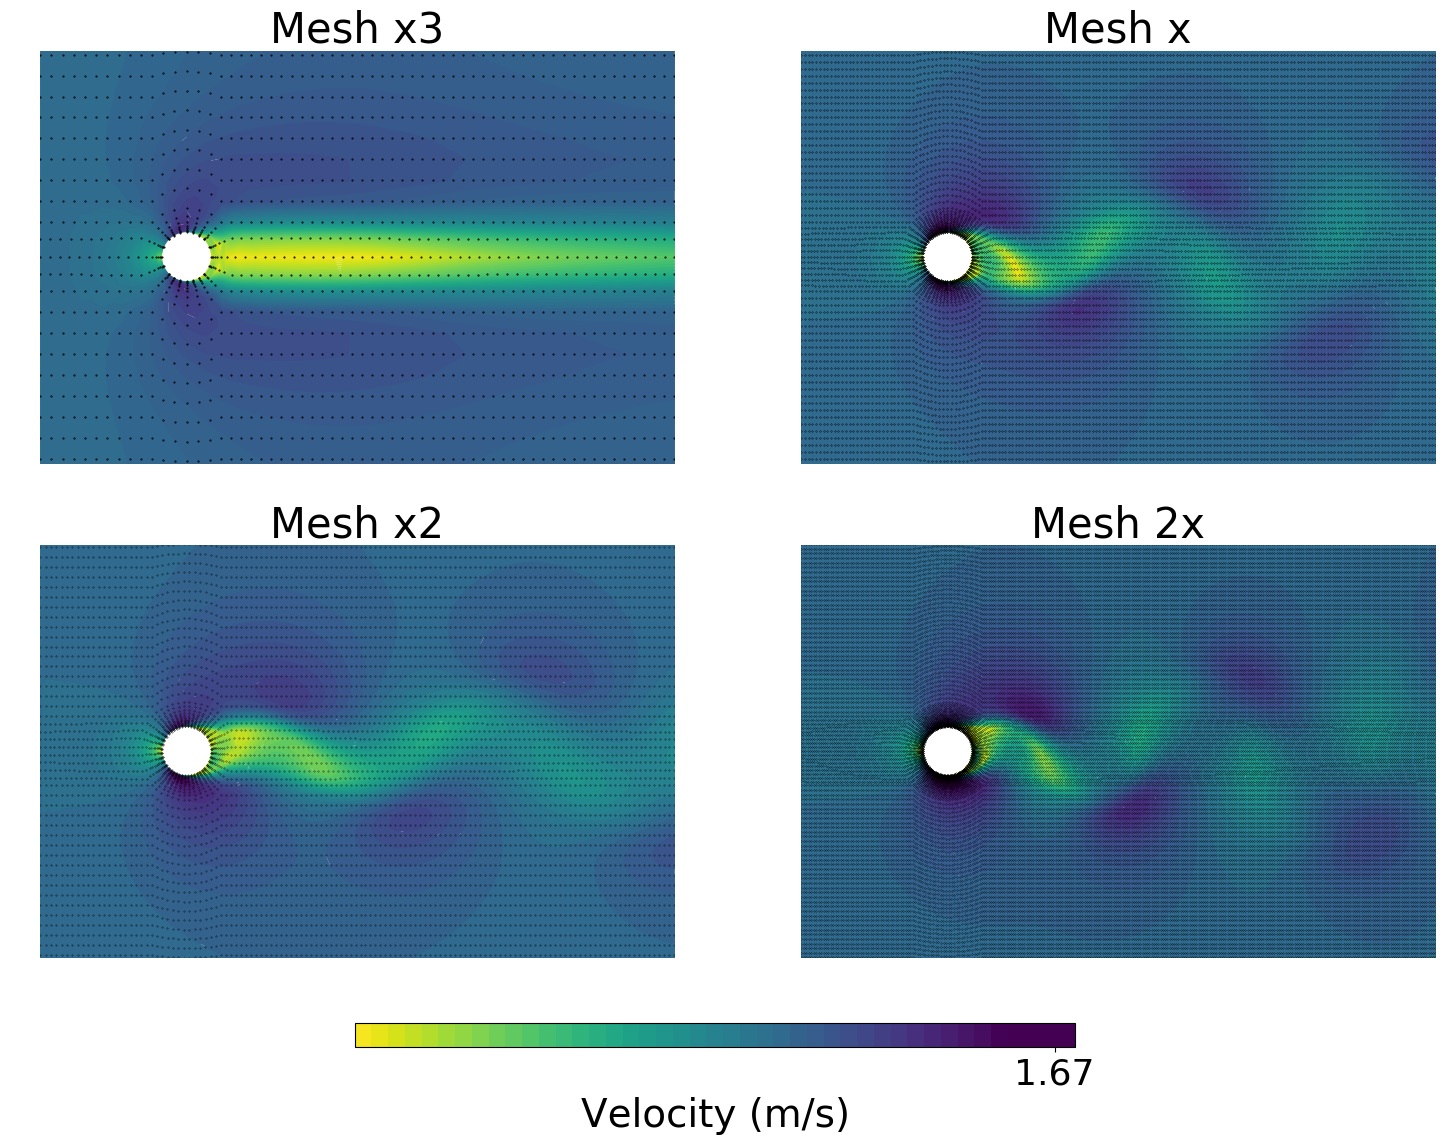

In [40]:
fig, ax = plt.subplots(2,2, sharex=True, figsize=(18,12), dpi=100)

levels = 50

for i in range(2):
    for j in range(2):
        k = i+2*j
        var = ax[i][j].tricontourf(dataSets[k][:,4], dataSets[k][:,5], np.sqrt(dataSets[k][:,1]**2+dataSets[k][:,2]**2+dataSets[k][:,3]**2), levels, cmap='viridis_r', vmin=minValV, vmax=maxValV)
        ax[i][j].plot(dataSets[k][:,4], dataSets[k][:,5], 'k.', markersize=1/(k+1))
        ax[i][j].add_patch(patches.Circle((0.0, 0.0), 0.5, facecolor="white"))
        ax[i][j].axis('equal')
        ax[i][j].axis('off')
        ax[i][j].set_title('Mesh %s' %dataSetsString[k], fontsize=30)

        for c in var.collections:
            c.set_edgecolor("face")
        
ccax = fig.add_axes([0.3, 0.05, 0.4, 0.02])
ccbar = fig.colorbar(var,  cax=ccax, orientation="horizontal")
ccbar.set_ticks([minVal,maxVal])
ccax.tick_params(axis = 'both', labelsize = 26)
ccbar.set_label('Velocity (m/s)', fontsize=28)

plt.savefig('./cylinderMeshConv_wGrid.png', bbox_inches='tight', dpi=300)

# Comparison of field data

In order to make the classical approach to mesh convergence, there is not a clear value to use. Also, there is a problem if the different fields are tried to be substracted, given that the array size is not the same for each case (the number of cells in each case is not the same). In order to face this problem, grid interpolation will be used, comparing different meshes one-by-one.

In [5]:
# Objective grid to interpolate (the same for all cases)
xi = np.linspace(-3,10,200)
yi = np.linspace(-5,5,200)
xi, yi = np.meshgrid(xi,yi)

# Interpolation for each case - to have a full array with xi and yi as axis
case = np.zeros((len(dataSets), np.shape(yi)[0], np.shape(yi)[1], 3))
for i in range(len(dataSets)):
    case[i,:,:,0] = griddata((dataSets[i][:,4],dataSets[i][:,5]),dataSets[i][:,0],(xi,yi),method='linear')
    case[i,:,:,1] = griddata((dataSets[i][:,4],dataSets[i][:,5]),dataSets[i][:,1],(xi,yi),method='linear')
    case[i,:,:,2] = griddata((dataSets[i][:,4],dataSets[i][:,5]),dataSets[i][:,2],(xi,yi),method='linear')

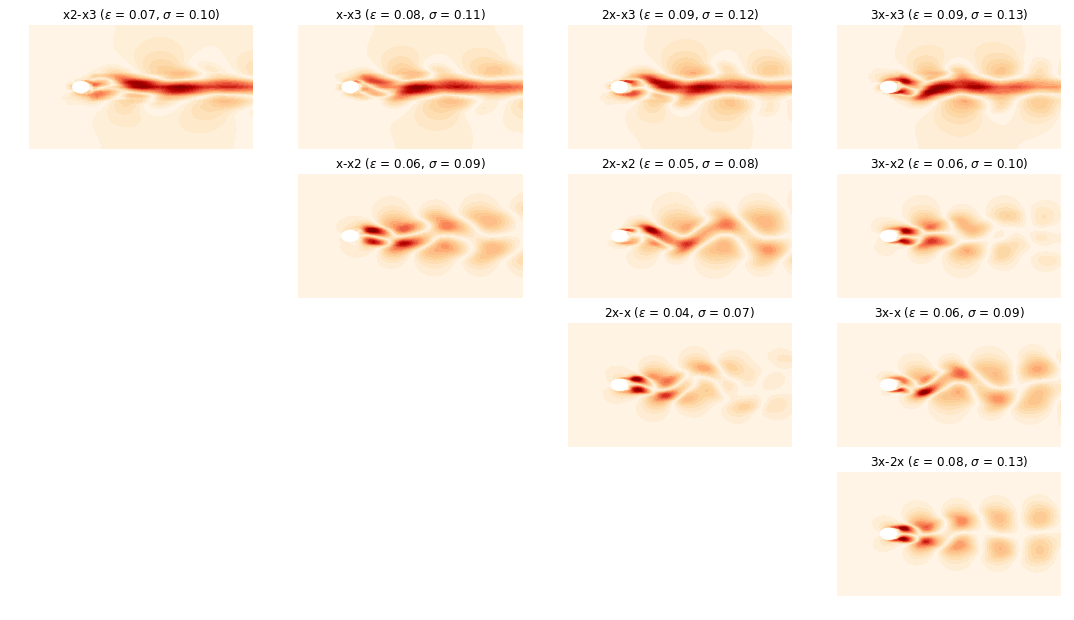

In [6]:
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8), (ax9, ax10, ax11, ax12), (ax13, ax14, ax15, ax16)) = plt.subplots(4, 4, sharex='col', sharey='row')
fig.set_size_inches(18.5, 10.5)
levels = 20

#Let's make a little space for the same-field comparison plots
ax5.axis('off')
ax9.axis('off')
ax10.axis('off')
ax13.axis('off')
ax14.axis('off')
ax15.axis('off')

realSubplot = [ax1, ax2, ax3, ax4, ax6, ax7, ax8, ax11, ax12, ax16]
comparative = [[1,0],[2,0],[3,0],[4,0],[2,1],[3,1],[4,1],[3,2],[4,2],[4,3]]
mean = np.zeros(len(comparative))
std = np.zeros(len(comparative))

#Let's plot the other cases
for i in range(len(realSubplot)):
    CS = realSubplot[i].contourf(xi, yi, abs(case[comparative[i][0],:,:,1]-case[comparative[i][1],:,:,1]), levels, cmap='OrRd')
    realSubplot[i].add_patch(patches.Circle((0.0, 0.0), 0.5, facecolor="white"))
    realSubplot[i].axis('off')
    mean[i]  = np.mean(abs(case[comparative[i][0],:,:,1]-case[comparative[i][1],:,:,1]))
    std[i] = np.std(abs(case[comparative[i][0],:,:,1]-case[comparative[i][1],:,:,1]))
    realSubplot[i].set_title(r'%s-%s ($\varepsilon$ = %.2f, $\sigma$ = %.2f)' %(dataSetsString[comparative[i][0]], dataSetsString[comparative[i][1]], mean[i], std[i]))

# Comparison with mesh properties

In [36]:
# Manually introduced values for the meshes (obtained with checkMesh)
nodes = np.array([3350, 14144, 28890, 64684, 114420])
faces = np.array([6415, 27694, 56925, 128084, 227130])
volumes = np.array([1580, 6874, 14160, 31814, 56640])

### Are the different mesh parameters related among them?

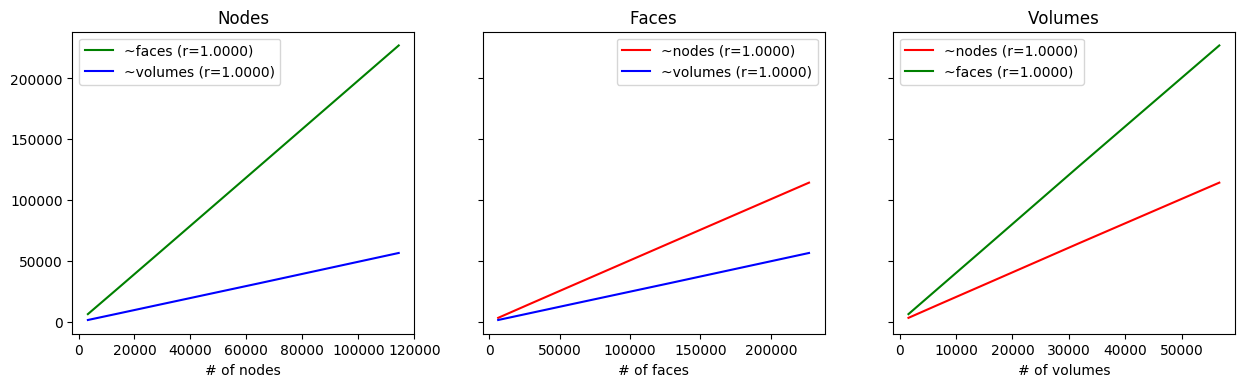

In [8]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15,4), dpi=100)
ax1.plot(nodes,faces,'g',label='~faces (r=%.4f)' %np.corrcoef(nodes,faces)[1,0])
ax1.plot(nodes,volumes,'b',label='~volumes (r=%.4f)' %np.corrcoef(nodes,volumes)[1,0])
ax1.set_xlabel('# of nodes')
ax1.set_title('Nodes')
ax1.legend()
ax2.plot(faces,nodes,'r',label='~nodes (r=%.4f)' %np.corrcoef(faces, nodes)[1,0])
ax2.plot(faces,volumes,'b',label='~volumes (r=%.4f)' %np.corrcoef(faces, volumes)[1,0])
ax2.set_xlabel('# of faces')
ax2.set_title('Faces')
ax2.legend()
ax3.plot(volumes,nodes,'r',label='~nodes (r=%.4f)' %np.corrcoef(volumes, nodes)[1,0])
ax3.plot(volumes,faces,'g',label='~faces (r=%.4f)' %np.corrcoef(volumes, faces)[1,0])
ax3.set_xlabel('# of volumes')
ax3.set_title('Volumes')
ax3.legend()

All of they are correlated, so no matter which one we choose to analyze mesh convergence. Let's go with nodes

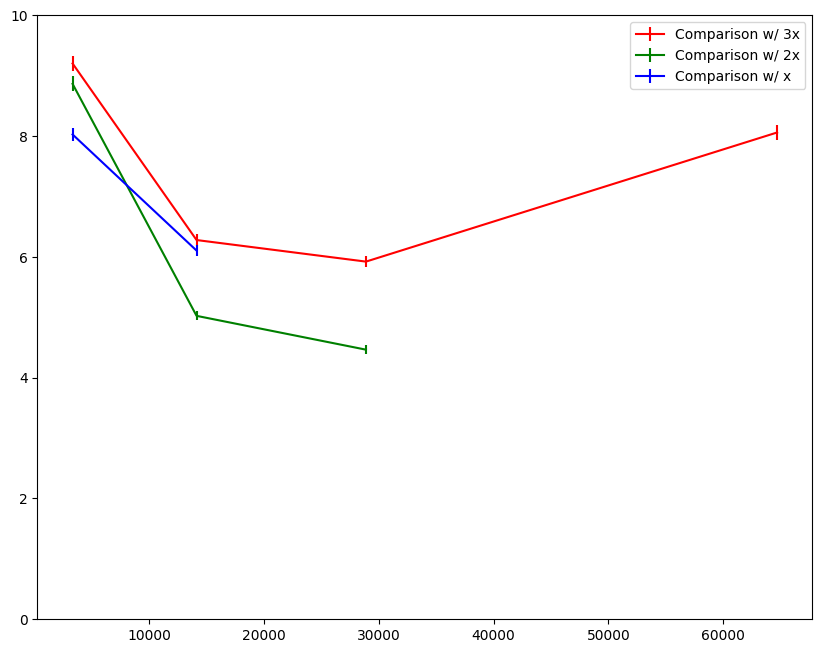

In [9]:
f, (ax1) = plt.subplots(1, figsize=(10,8), dpi=100)
ax1.errorbar(nodes[:-1], 100*mean[[3,6,8,9]], std[[3,6,8,9]], color = 'r', label='Comparison w/ 3x')
ax1.errorbar(nodes[:-2], 100*mean[[2,5,7]], std[[2,5,7]], color = 'g', label='Comparison w/ 2x')
ax1.errorbar(nodes[:-3], 100*mean[[1,4]], std[[1,4]], color = 'b', label='Comparison w/ x')
ax1.set_ylim([0,10])
ax1.legend()